In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 158M/158M [00:01<00:00, 95.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


In [ ]:
test_path = path + '/Covid19-dataset/test/'
train_path = path + '/Covid19-dataset/train/'

In [ ]:
image_classes = os.listdir(train_path)
image_classes

['Normal', 'Viral Pneumonia', 'Covid']

# **4.1 EDA and data preprocessing 	(5b)**

**(A-4b)	EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu**

In [ ]:
normal = [img for img in os.listdir(train_path + 'Normal') if img.endswith('.jpeg')]
pneumonia = [img for img in os.listdir(train_path + 'Viral Pneumonia') if img.endswith('.jpeg')]
covid = [img for img in os.listdir(train_path + 'Covid') if img.endswith('.jpeg')]

print(f'Normal: {len(normal)}')
print(f'Viral Pneumonia: {len(pneumonia)}')
print(f'Covid: {len(covid)}')

Normal: 70
Viral Pneumonia: 70
Covid: 46


Vizualizujeme si surové dáta

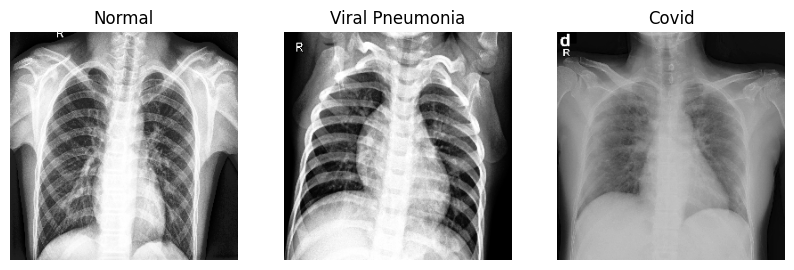

In [ ]:
plt.figure(figsize=(10,10))
for i, image_class in enumerate(image_classes):
    image_path = train_path + image_class

    img = np.random.choice(os.listdir(image_path), replace=False)
    img = image_path + '/' + img

    img = keras.preprocessing.image.load_img(img, target_size=(256,256), color_mode='grayscale')
    img = keras.preprocessing.image.img_to_array(img)/255

    plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='Greys_r')
    plt.title(image_class)
    plt.axis('off')

plt.show()

In [ ]:
image_data_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [ ]:
# creating train, validation and test data from directories
train_data = image_data_generator.flow_from_directory(train_path,
                                                      target_size=(256,256),
                                                      color_mode='grayscale',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='training',
                                                      shuffle=True,)

validation_data = image_data_generator.flow_from_directory(train_path,
                                                           target_size=(256,256),
                                                           color_mode='grayscale',
                                                           batch_size=16,
                                                           class_mode='categorical',
                                                           subset='validation')
img_data_generator = ImageDataGenerator(rescale=1/255)
test_data = img_data_generator.flow_from_directory(test_path,
                                                   target_size=(256,256),
                                                   color_mode='grayscale',
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


**(B-1b)	Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2**

**EDA**

Pri predspracovaní dát smezistili, že obrázky pocházdajú z troch rôznych kategórií (Normal, Viral Pneumonia, Covid). Obrázky zmenšujeme na veľkosť 256x256 pixelov aby sme zaistili konzistentnosť medzi dátami a každý obrázok načítavame v odieňoch sivej (grayscale) aby sme mali istotu, že každý obrázok má naozaj rovnaké farby. Po týchto úpravých sme rozdelili trénovací dataset na validačný a trenovací

**DL Metódy**

Na clasifikáciu obrázkov použijeme konvolučnú neurónovú sieť (CNN), ktoré sú najvhodnejšie pre naučenie sa rôznych poznávacích čŕt v obrázkoch. Súčasťou tejto CNN sú konvolučné vrstvy ktoré extrahujú vzory z obrázkov, následne maxpooling ktoré slúžia na downsampling a pomáhajú modelu generalizovať. Následne použijeme Droupout aby sa predišlo overfitu.

# **4.2. Modeling and evaluation (5b)**

**(A-4b)	Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL	metód. Výsledok modelovania je najlepší model.**

In [ ]:
# input shape
for batch, labels in train_data:
    input_shape = list(batch.shape[1:])
    print(input_shape)
    print(labels)
    break

[256, 256, 1]
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
# CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,525,891 (120.26 MB)

 Trainable params: 31,525,891 (120.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_data,
                    batch_size=32, epochs=8,
                    validation_data=validation_data,
                    validation_batch_size=32)

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.3610 - loss: 4.8772 - val_accuracy: 0.6200 - val_loss: 0.8585
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7405 - loss: 0.5924 - val_accuracy: 0.7400 - val_loss: 0.9175
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8504 - loss: 0.4453 - val_accuracy: 0.8600 - val_loss: 0.7229
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8467 - loss: 0.3317 - val_accuracy: 0.8400 - val_loss: 0.5602
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9259 - loss: 0.1708 - val_accuracy: 0.8600 - val_loss: 0.4357
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9424 - loss: 0.1804 - val_accuracy: 0.8800 - val_loss: 0.3521
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9405 - loss: 0.1250 - val_accuracy: 0.9000 - val_loss: 0.2806
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9539 - loss: 0.1019 - val_accuracy: 0.9200 - val_loss: 0.2775


In [ ]:
loss, acc = model.evaluate(validation_data, batch_size=32)
print(f'Loss: {round(loss, 3)}, Acc: {round(acc*100, 3)}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.9201 - loss: 0.2795
Loss: 0.277, Acc: 92.0%


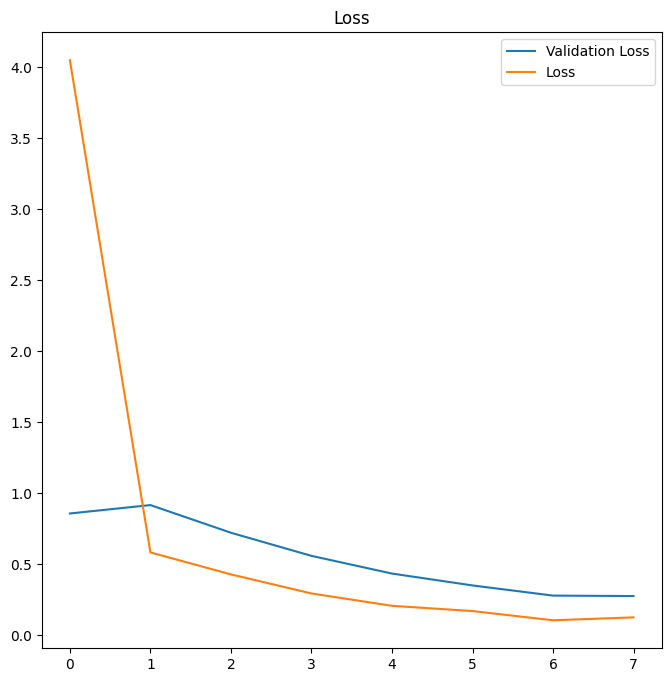

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(range(8), history.history['val_loss'], label='Validation Loss')
plt.plot(range(8), history.history['loss'], label='Loss')
plt.title('Loss')
plt.legend()
plt.show()

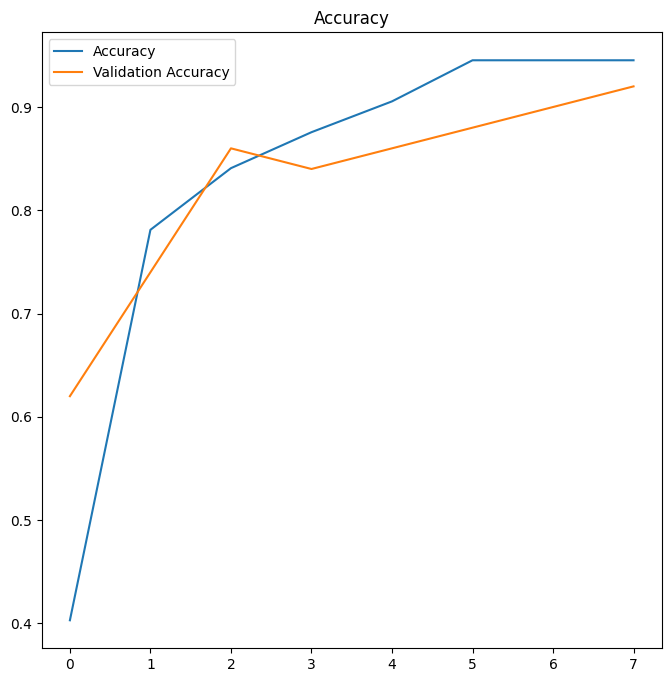

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(range(8), history.history['accuracy'], label='Accuracy')
plt.plot(range(8), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
testing_labels = []
testing_batch = []

for batch, labels in train_data:
    testing_batch = batch
    testing_labels = labels
    break

label_indices = np.argmax(testing_labels, axis=1)
real_labels = [image_classes[x] for x in label_indices]

In [ ]:
predictions = model.predict(testing_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


In [ ]:
output = []
for pred in predictions:
    output.append(image_classes[np.argmax(pred)])

In [ ]:
predicted_data = pd.DataFrame({'Predicion': output, 'Real class': real_labels})
predicted_data

,Predicion,Real class
0,Viral Pneumonia,Viral Pneumonia
1,Normal,Normal
2,Normal,Normal
3,Covid,Covid
4,Normal,Normal
5,Normal,Normal
6,Viral Pneumonia,Viral Pneumonia
7,Viral Pneumonia,Viral Pneumonia
8,Normal,Normal
9,Viral Pneumonia,Viral Pneumonia


**(B-1b)	Zhodnotíte Váš prístup a získaný výsledok**

Skúšali sme rôzne nastavenia vrstiev našej sieti a ako najlepší výsledok nám vyšlo použitie troch kovolučných vrstie spolu s maxpooling a droupoutom s výsledkom presnosti 92%. Na grafoch je vidno, že rozdiel medzi treningovou presnesťou a validačnou je veľmi malý čo dokazuje, že náš model netrpí ani overfitom ani underfitom a dokáže sa dobre učiť z poskytnutých dát.

Na záver sme model otestovali na testovacom datasete a je vidno, že model vie naozja veľmi dobre klasifikovať dané obrázky